Systematic Uncertainty Modelling
===

In the `Neural_Likelihood_Ratio_Estimation.ipynb` notebook, we left out the nuisance parameter piece of the parameterized density ratio decomposition:

$$g_c(x|\alpha) = \frac{p_c(x|\alpha)}{p_c(x)} = \prod_m \frac{p_c(x|\alpha_m^{eval})}{p_c(x)}$$

where the second equality assumes that **the effect of various sources of uncertainty in the model can be factorized**. This is another density ratio estimation problem, but instead of training m $\alpha-$parameterized NNs, we use a HistFactory-style interpolation generalized to a per-event formulation:

$$\frac{p_c(x|\alpha_m^{eval})}{p_c(x)} = \begin{cases}
    \left(\frac{p_c(x|\alpha_m^+)}{p_c(x)}\right)^{\alpha_m^\text{eval}}& \alpha_m^\text{eval}>1\\
    1+\sum_{n=1}^6c_n\cdot (\alpha_m^\text{eval})^n& -1\leq\alpha_m^\text{eval}\leq 1\\
    \left(\frac{p_c(x|\alpha_m^-)}{p_c(x)}\right)^{-\alpha_m^\text{eval}}& \alpha_m^\text{eval}<-1\\
    \end{cases}$$

where $\alpha=\{\alpha_m^{eval}\}$ and for each nuisance parameter $m$, we have three simulation models - $p_c(x), p_c(x|\alpha_m^+), p_c(x|\alpha_m^-)$. Naturally, this still requires NNs to estimate the density ratios:

$$\frac{p_c(x|\alpha_m^+)}{p_c(x)} \, , \frac{p_c(x|\alpha_m^-)}{p_c(x)}$$

**These are the density ratios that we will estimate using NNs in this notebook.**
Two ratios corresponding to each $\alpha_m^\pm$ will be trained for each systematic uncertainty indexed by $m$ and for each channel $c$ to build the final parameterized model, 

$$\frac{p(x|\mu, \alpha)}{p_{ref}(x)} = \frac{1}{\sum_c G_c(\alpha) \cdot f_c(\mu) \cdot \nu_c} \sum_c f_c(\mu) \cdot G_c(\alpha) \cdot \nu_c \cdot g_c(x|\alpha) \cdot \frac{p_c\left(x\right)}{p_{ref}(x)}$$

The full workflow for building $\mu, \alpha-$parameterized density ratios is represented in the flowchart below:

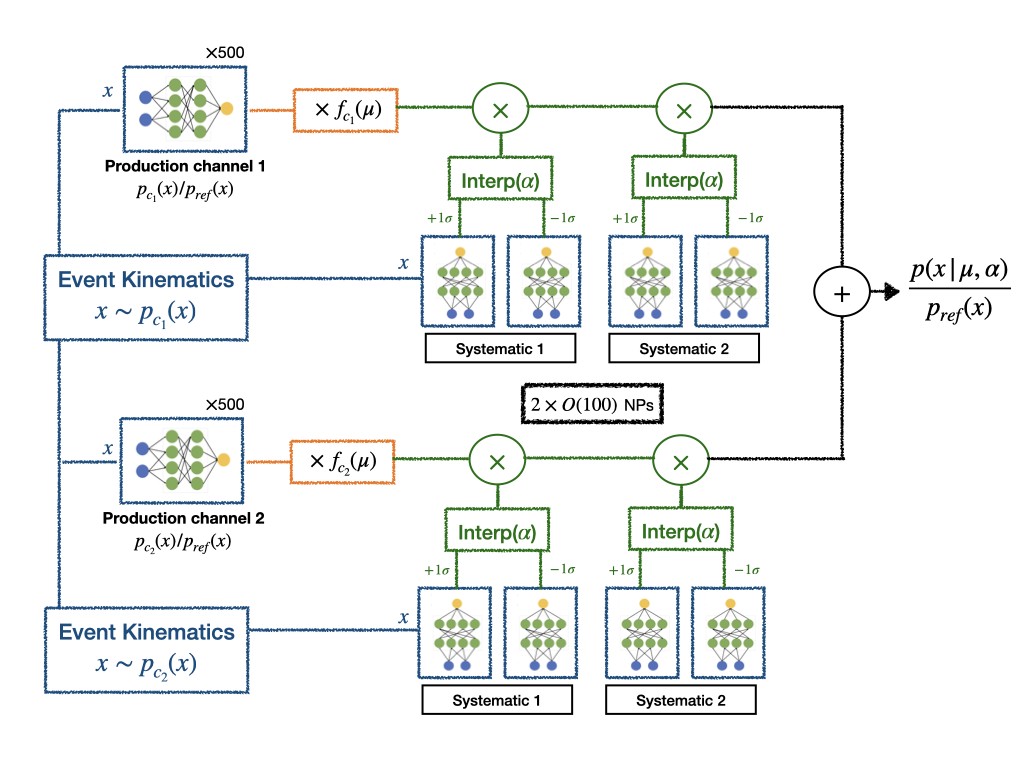

In [1]:
import os, sys, importlib
# sys.path.append('/home/jaySandesara/NSBI_workflow_tutorial/FAIR_universe_Higgs_tautau/')

import nsbi_common_utils
from nsbi_common_utils import plotting, training, datasets, configuration
from nsbi_common_utils.training import TrainEvaluate_NN, TrainEvaluatePreselNN

from utils import calculate_preselection_observable, preselection_using_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.optimizers import Nadam
import mplhep as hep
import matplotlib.pyplot as plt
import pickle
import yaml
import random
import numpy as np

from coffea.analysis_tools import PackedSelection

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

hep.style.use(hep.style.ATLAS)

/home/jsandesara_umass_edu/NSBI-workflow-tutorial/src/nsbi_common_utils/plotting.py:11: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style("ATLAS")
2025-09-03 16:56:30.820619: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-03 16:56:30.840988: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-03 16:56:30.847190: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-03 16:56:30.863036: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CP

In [3]:
importlib.reload(sys.modules['nsbi_common_utils.configuration'])
from nsbi_common_utils import configuration

config = nsbi_common_utils.configuration.ConfigManager(file_path_string = './config.yml')


In [4]:
config.config["Regions"][2]["Variable"]

In [5]:
# Input features for training
features, features_scaling = config.get_training_features()

In [6]:
importlib.reload(sys.modules['nsbi_common_utils.datasets'])
from nsbi_common_utils import datasets

branches_to_load = features + ['presel_score']

Datasets = nsbi_common_utils.datasets.datasets(config_path = './config.yml',
                                                branches_to_load =  branches_to_load)

dataset_incl_dict = Datasets.load_datasets_from_config(load_systematics = True)


In [7]:
dataset_SR_dict = Datasets.filter_region_by_type(dataset_incl_dict, region = "SR")

Density ratio training
===

Now we train the NNs to predict two ratios,

$$\frac{p_c(x|\alpha_m^+)}{p_c(x)} \, , \frac{p_c(x|\alpha_m^-)}{p_c(x)}$$

for each nuisance parameter $\alpha_m$, for each process $p_c$ that is affected by the corresponding nuisance parameter.

Here is a major computational bottleneck of this workflow - for $N_{syst}$ systematics affecting each of the $N_{proc}$ processes, we would need a total of 

$$N_{syst} \times N_{proc} \times 2$$

well-trained NNs. In our example with $N_{syst}=2$ and $N_{proc}=3$, this corresponds to a total of 12 NNs. Typically in LHC experiments $N_{syst}\approx O(10^2)$! This type of approach thus requires a GPU infrastructure for efficient optimizations.

In [8]:
importlib.reload(sys.modules['nsbi_common_utils.training'])
from nsbi_common_utils.training import TrainEvaluate_NN

PATH_TO_SAVED_DATA = './saved_data/'

NN_training_syst_process  = {}
path_to_ratios            = {}
path_to_figures           = {}
path_to_models            = {}

# rnd_seed_traintestsplit = 42 # can also be randomized, fixed for now
rnd_seed_traintestsplit = random.randint(0, 2**32 - 1)

# DELETE_EXISTING_MODELS = True
DELETE_EXISTING_MODELS = False


for process in config.get_basis_samples():
    
    NN_training_syst_process[process]   = {}
    path_to_ratios[process]             = {}
    path_to_figures[process]            = {}
    path_to_models[process]             = {}

    _train_label_sample_dict = {process        : 0}

    dataset_den             = Datasets.merge_dataframe_dict_for_training(dataset_SR_dict["Nominal"], 
                                                                _train_label_sample_dict, 
                                                                samples_to_merge = [process])
    
    
    for dict_syst in config.config["Systematics"]:
        
        syst = dict_syst["Name"]

        NN_training_syst_process[process][syst] = {}
        path_to_ratios[process][syst]           = {}
        path_to_figures[process][syst]          = {}
        path_to_models[process][syst]           = {}

        for direction in ["Up", "Dn"]:
            
            samples_to_train = config.get_samples_in_syst_for_training(syst, direction)
            
            if (process not in samples_to_train):
                print(f"Nothing to train for {process} in {syst+direction} uncertainty")
                del NN_training_syst_process[process][syst], path_to_ratios[process][syst], path_to_figures[process][syst], path_to_models[process][syst]
                continue

            syst_key_name = syst + '_' + direction
            
            _train_label_sample_dict = {process        : 1}

            dataset_num             = Datasets.merge_dataframe_dict_for_training(dataset_SR_dict[syst_key_name], 
                                                                                _train_label_sample_dict, 
                                                                                samples_to_merge = [process])

            # Save paths
            top_path                                    = f'{PATH_TO_SAVED_DATA}output_training_systematics/'
            output_name                                 = f'{process}_{syst}_{direction}'
            output_dir                                  = f'{top_path}general_output_{output_name}'
            path_to_ratios[process][syst][direction]    = f'{top_path}output_ratios_{output_name}/'
            path_to_figures[process][syst][direction]   = f'{top_path}output_figures_{output_name}/'
            path_to_models[process][syst][direction]    = f'{top_path}output_model_params_{output_name}/'
            
            # Build a training dataset for the training of p_<process_type>/p_<REF_PROCESSES> density ratio
            dataset_syst_nom = pd.concat([dataset_num, dataset_den])
            
            NN_training_syst_process[process][syst][direction] = TrainEvaluate_NN(dataset_syst_nom, 
                                                                                   dataset_syst_nom['weights_normed'].to_numpy(),
                                                                                   dataset_syst_nom['train_labels'].to_numpy(),
                                                                                   features, 
                                                                                   features_scaling,
                                                                                   [syst+'_'+direction, process], 
                                                                                  output_dir, output_name, 
                                                                                    path_to_figures=path_to_figures[process][syst][direction],
                                                                                    path_to_ratios=path_to_ratios[process][syst][direction], 
                                                                                    path_to_models=path_to_models[process][syst][direction],
                                                                                    delete_existing_models = DELETE_EXISTING_MODELS)
                


In [9]:
# For systematic uncertainty variations, we can use a calibration layer to regularize the small fluctuations in density ratio output
doCalibration = True
num_bins_cal = 50

USE_SAVED_MODELS = True
RECALIBRATE = True
num_ensemble_members = 1

plot_scaled_features = False

verbose_output = 1

scalerType = 'MinMax'
hidden_layers = 4
num_neurons = 1000
num_epochs = 100
batch_size = 10_000
initial_lr = 0.1

for process, process_dict in NN_training_syst_process.items():

    for syst, syst_dict in process_dict.items():
        
        for direction in syst_dict.keys():

            NN_training_syst_process[process][syst][direction].train_ensemble (  hidden_layers        = hidden_layers, 
                                                                                 neurons              = num_neurons, 
                                                                                 number_of_epochs     = num_epochs, 
                                                                                 batch_size           = batch_size, 
                                                                                 learning_rate        = initial_lr, 
                                                                                 scalerType           = scalerType, 
                                                                                 calibration          = doCalibration, 
                                                                                 num_bins_cal         = num_bins_cal, 
                                                                                 callback             = True, 
                                                                                 callback_patience    = 30, 
                                                                                 callback_factor      = 0.01,
                                                                                 verbose              = verbose_output,
                                                                                 plot_scaled_features = plot_scaled_features,
                                                                                 load_trained_models  = USE_SAVED_MODELS,
                                                                                 recalibrate_output   = RECALIBRATE,
                                                                                 num_ensemble_members = num_ensemble_members
                                                                            )    
            
            NN_training_syst_process[process][syst][direction].test_normalization ( )    
            

starting ensemble training
Loading existing model for ensemble member 0
Reading saved models from ./saved_data/output_training_systematics/output_model_params_htautau_JES_Up/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Calibrating the saved model with 50 bins


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 1.0000302754107306


The sum of PDFs using the whole ensemble is 1.0000302754107306



starting ensemble training
Loading existing model for ensemble member 0
Reading saved models from ./saved_data/output_training_systematics/output_model_params_htautau_JES_Dn/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Calibrating the saved model with 50 bins


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 0.9999591566148937


The sum of PDFs using the whole ensemble is 0.9999591566148937



starting ensemble training
Loading existing model for ensemble member 0
Reading saved models from ./saved_data/output_training_systematics/output_model_params_htautau_TES_Up/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Calibrating the saved model with 50 bins


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 0.9999495565146149


The sum of PDFs using the whole ensemble is 0.9999495565146149



starting ensemble training
Loading existing model for ensemble member 0
Reading saved models from ./saved_data/output_training_systematics/output_model_params_htautau_TES_Dn/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Calibrating the saved model with 50 bins


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 1.0000095795472963


The sum of PDFs using the whole ensemble is 1.0000095795472963



starting ensemble training
Loading existing model for ensemble member 0
Reading saved models from ./saved_data/output_training_systematics/output_model_params_ttbar_JES_Up/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 1.0002567738210044


The sum of PDFs using the whole ensemble is 1.0002567738210044



starting ensemble training
Loading existing model for ensemble member 0
Reading saved models from ./saved_data/output_training_systematics/output_model_params_ttbar_JES_Dn/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 1.000216912688712


The sum of PDFs using the whole ensemble is 1.000216912688712



starting ensemble training
Loading existing model for ensemble member 0
Reading saved models from ./saved_data/output_training_systematics/output_model_params_ttbar_TES_Up/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 1.000169713750127


The sum of PDFs using the whole ensemble is 1.000169713750127



starting ensemble training
Loading existing model for ensemble member 0
Reading saved models from ./saved_data/output_training_systematics/output_model_params_ttbar_TES_Dn/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 1.0002333567661816


The sum of PDFs using the whole ensemble is 1.0002333567661816



starting ensemble training
Loading existing model for ensemble member 0
Reading saved models from ./saved_data/output_training_systematics/output_model_params_ztautau_JES_Up/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Calibrating the saved model with 50 bins


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 1.0000638761070295


The sum of PDFs using the whole ensemble is 1.0000638761070295



starting ensemble training
Loading existing model for ensemble member 0
Reading saved models from ./saved_data/output_training_systematics/output_model_params_ztautau_JES_Dn/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Calibrating the saved model with 50 bins


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 1.0000368671584858


The sum of PDFs using the whole ensemble is 1.0000368671584858



starting ensemble training
Loading existing model for ensemble member 0
Reading saved models from ./saved_data/output_training_systematics/output_model_params_ztautau_TES_Up/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Calibrating the saved model with 50 bins


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 1.000019989014638


The sum of PDFs using the whole ensemble is 1.000019989014638



starting ensemble training
Loading existing model for ensemble member 0
Reading saved models from ./saved_data/output_training_systematics/output_model_params_ztautau_TES_Dn/


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Calibrating the saved model with 50 bins


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)






The sum of PDFs in ensemble member 0 is 1.0000524822465842


The sum of PDFs using the whole ensemble is 1.0000524822465842





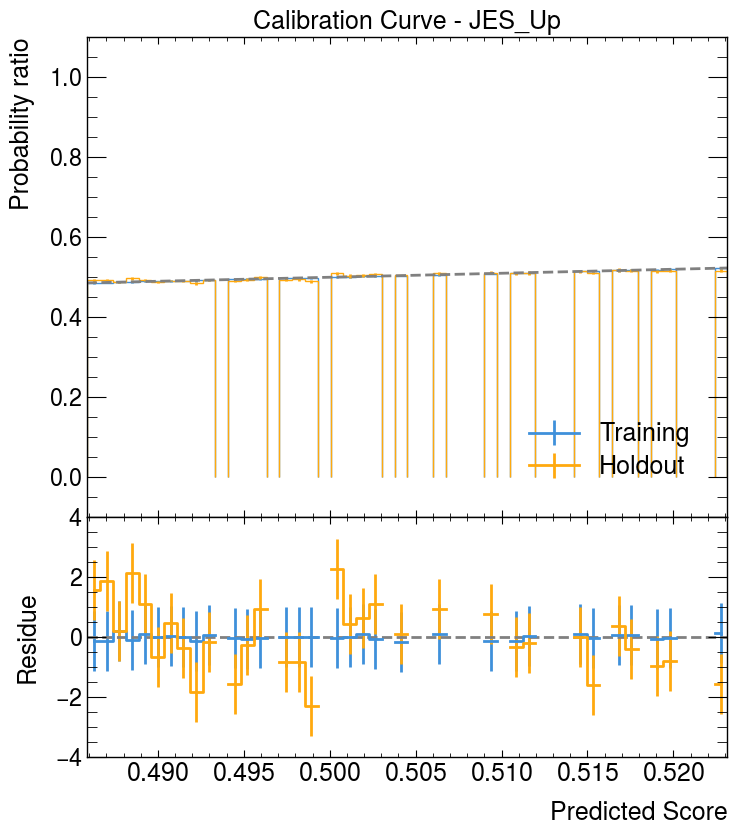

<Figure size 800x600 with 0 Axes>

In [10]:
num_bins_cal = 50
NN_training_syst_process["htautau"]["JES"]["Up"].make_calib_plots(nbins=num_bins_cal, observable='score')


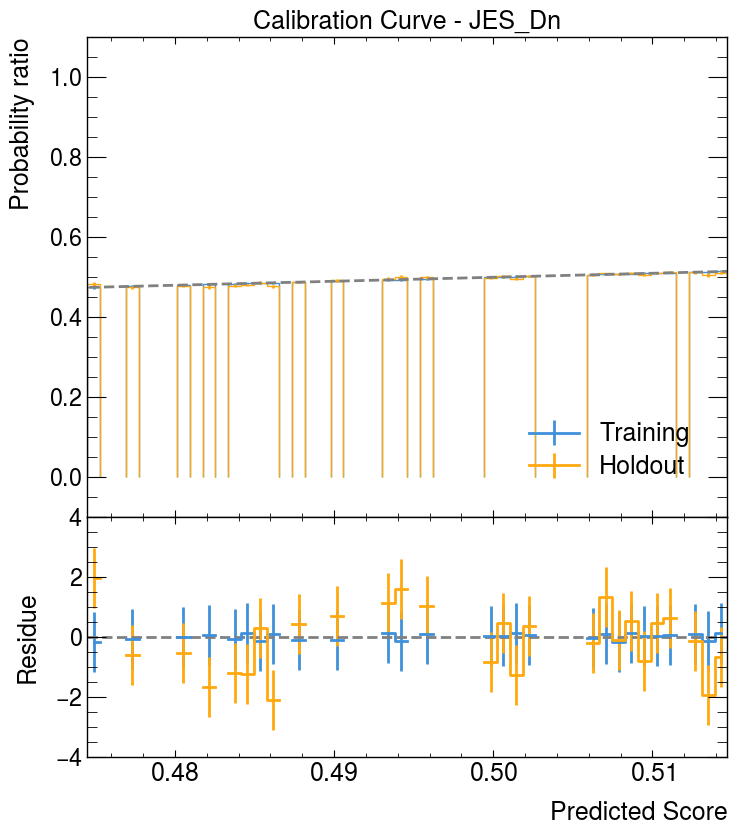

<Figure size 800x600 with 0 Axes>

In [11]:
num_bins_cal = 50
NN_training_syst_process["htautau"]["JES"]["Dn"].make_calib_plots(nbins=num_bins_cal, observable='score')


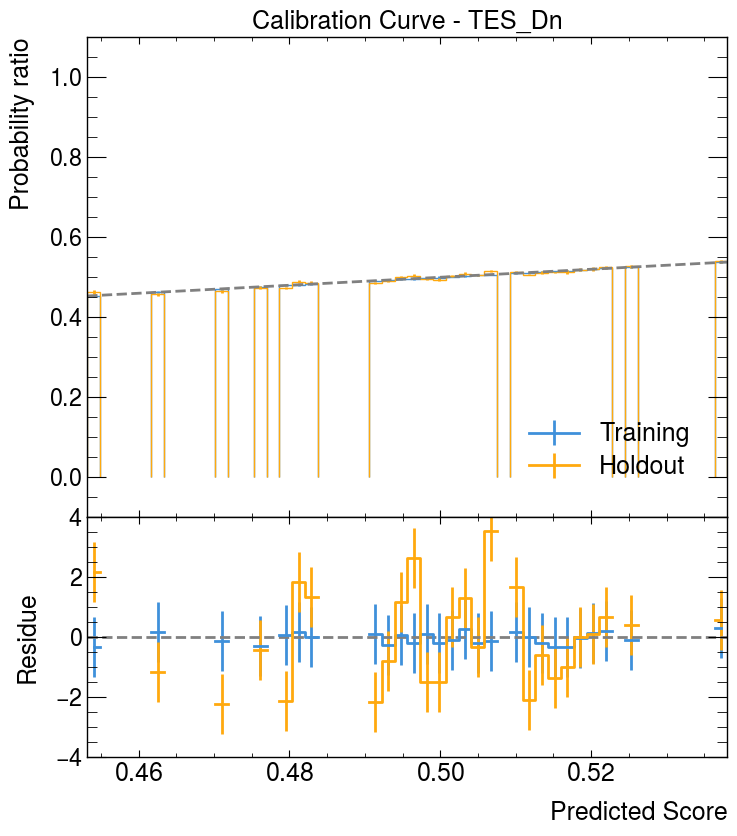

<Figure size 800x600 with 0 Axes>

In [12]:
num_bins_cal = 50
NN_training_syst_process["htautau"]["TES"]["Dn"].make_calib_plots(nbins=num_bins_cal, observable='score')


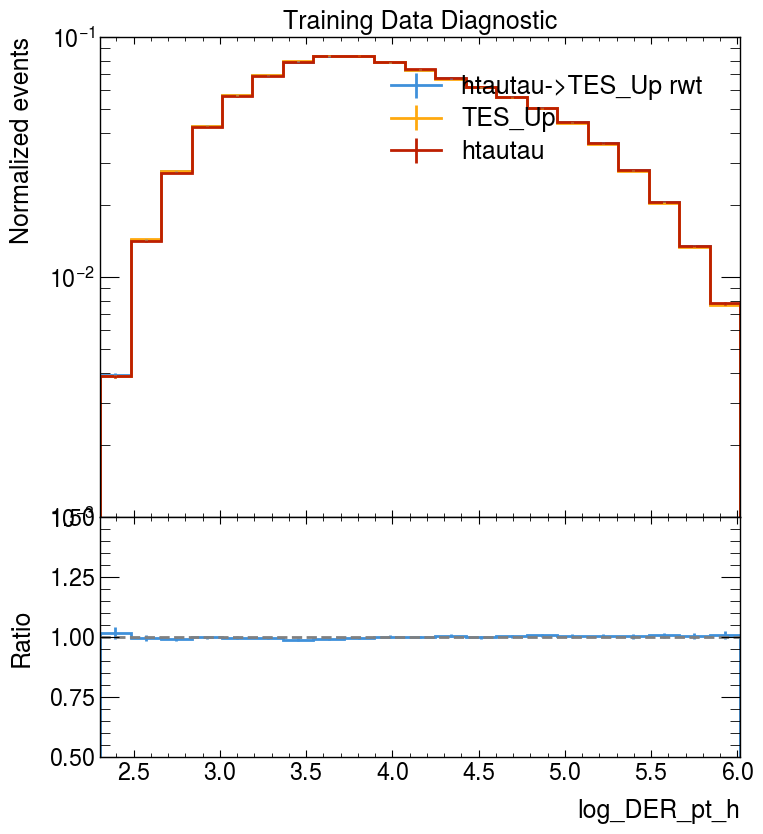

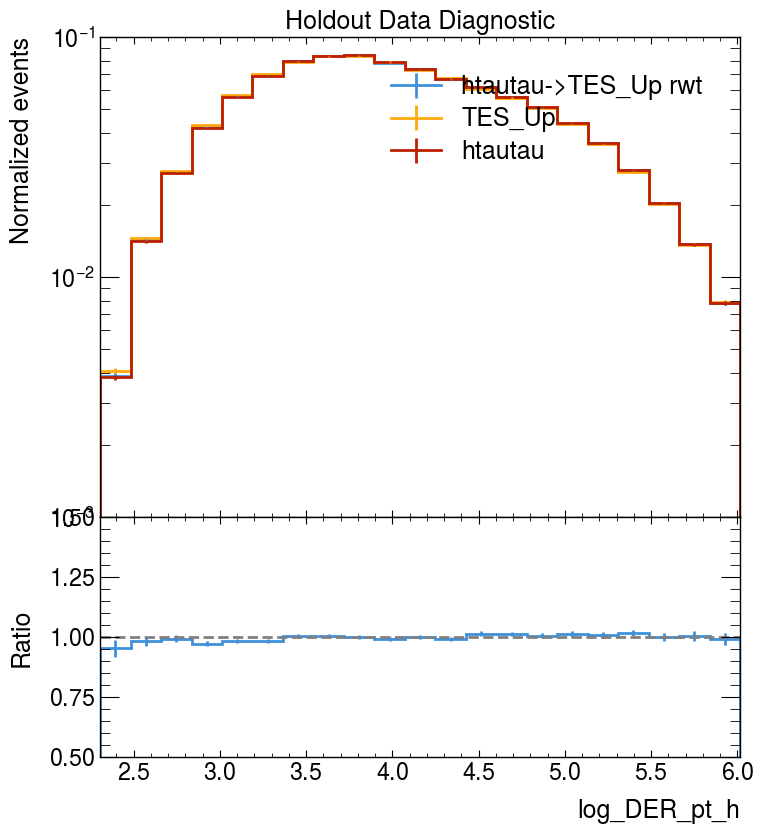

<Figure size 800x600 with 0 Axes>

In [13]:
variables_to_plot=['log_DER_pt_h'] # The 1D variable for reweighting closure
yscale_type='log'
num_bins_plotting=21

NN_training_syst_process["htautau"]["TES"]["Up"].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


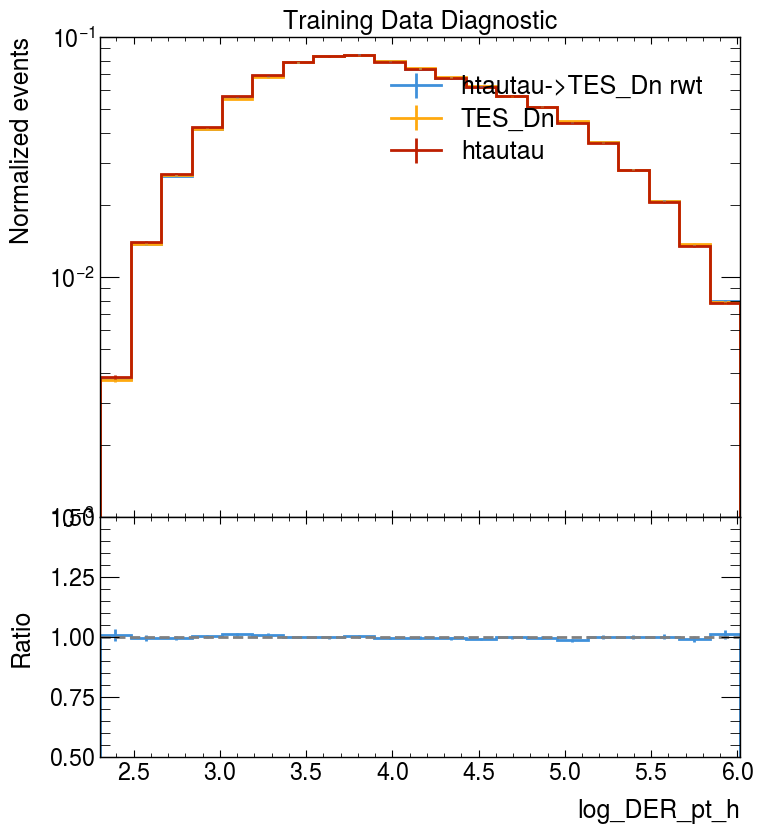

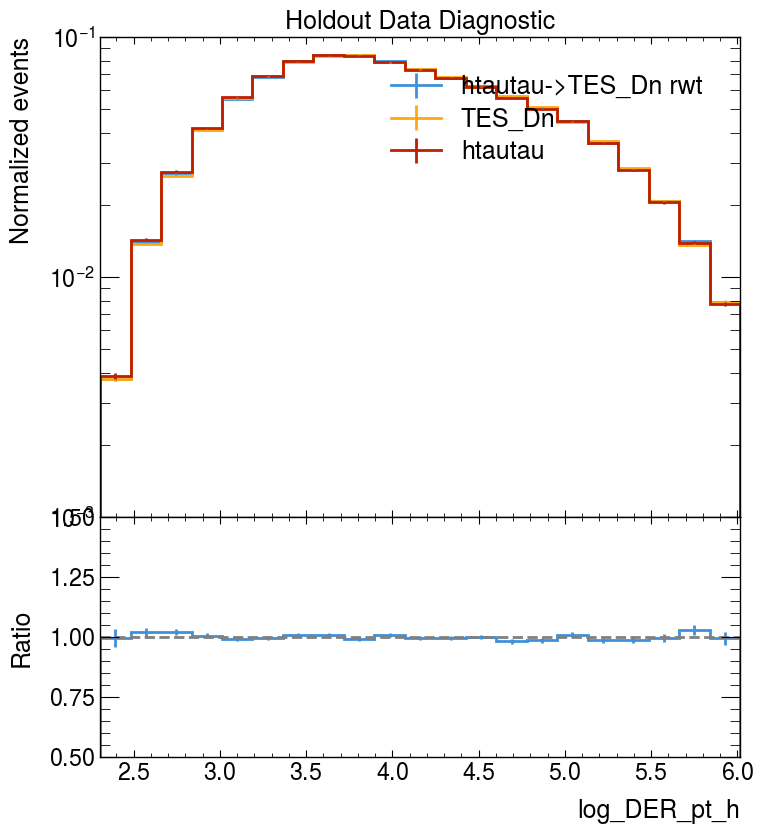

<Figure size 800x600 with 0 Axes>

In [14]:
variables_to_plot=['log_DER_pt_h'] # The 1D variable for reweighting closure
yscale_type='log'
num_bins_plotting=21

NN_training_syst_process["htautau"]["TES"]["Dn"].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


Save the model output
--

Save the density ratios corresponding to each NP $\alpha_m$ and process $p_c(x)$ as a set of `numpy` arrays for use in the `Parameter_Fitting_with_Systematics.ipynb` notebook.

The trained models are also saved automatically by the training class for direct use in inference, or for evaluating on real data.

In [19]:
ensemble_aggregation_type = 'mean_ratio'

path_to_load = "saved_datasets/dataset_Asimov.root"
dataset_Asimov_SR = nsbi_common_utils.datasets.load_dataframe_from_root(path_to_load     = path_to_load,
                                                                      tree_name        = "nominal",
                                                                      branches_to_load = branches_to_load)

path_to_saved_ratios = {}

for process in config.get_basis_samples():

    path_to_saved_ratios[process] = {}
    
    for dict_syst in config.config["Systematics"]:

        syst = dict_syst["Name"]
        
        if (process not in dict_syst["Samples"]) | (dict_syst["Type"] != "NormPlusShape"): continue

        path_to_saved_ratios[process][syst] = {}
        
        for direction in ["Up", "Dn"]:

            # Evaluate the density ratios p_alpha^\pm/p_nom for the nominal dataset
            path_to_saved_ratios[process][syst][direction] = NN_training_syst_process[process][syst][direction].evaluate_and_save_ratios(dataset_Asimov_SR, 
                                                                                        aggregation_type = ensemble_aggregation_type)


Evaluating density ratios


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
path_to_saved_ratios["htautau"]